# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_3A:cores+wisig -> oracle.run1.framed",
    "device": "cuda",
    "lr": 0.001,
    "x_shape": [2, 200],
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 16000, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10.",
                "1-11.",
                "1-15.",
                "1-16.",
                "1-17.",
                "1-18.",
                "1-19.",
                "10-4.",
                "10-7.",
                "11-1.",
                "11-14.",
                "11-17.",
                "11-20.",
                "11-7.",
                "13-20.",
                "13-8.",
                "14-10.",
                "14-11.",
                "14-14.",
                "14-7.",
                "15-1.",
                "15-20.",
                "16-1.",
                "16-16.",
                "17-10.",
                "17-11.",
                "17-2.",
                "19-1.",
                "19-16.",
                "19-19.",
                "19-20.",
                "19-3.",
                "2-10.",
                "2-11.",
                "2-17.",
                "2-18.",
                "2-20.",
                "2-3.",
                "2-4.",
                "2-5.",
                "2-6.",
                "2-7.",
                "2-8.",
                "3-13.",
                "3-18.",
                "3-3.",
                "4-1.",
                "4-10.",
                "4-11.",
                "4-19.",
                "5-5.",
                "6-15.",
                "7-10.",
                "7-14.",
                "8-18.",
                "8-20.",
                "8-3.",
                "8-8.",
            ],
            "domains": [1, 2, 3, 4, 5],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/cores.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["take_200"],
            "episode_transforms": [],
            "domain_prefix": "C_A_",
        },
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": 100,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["take_200"],
            "episode_transforms": [],
            "domain_prefix": "W_A_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["take_200", "resample_20Msps_to_25Msps"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
    ],
    "seed": 7,
    "dataset_seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'C_A_2', 'C_A_5', 'C_A_1', 'W_A_1', 'W_A_4', 'C_A_4', 'W_A_3', 'W_A_2', 'C_A_3'}


{'ORACLE.run1_44', 'ORACLE.run1_26', 'ORACLE.run1_32', 'ORACLE.run1_14', 'ORACLE.run1_8', 'ORACLE.run1_38', 'ORACLE.run1_20', 'ORACLE.run1_50'}


tensor([[[-0.0268, -0.0343,  0.0003,  ..., -0.0336, -0.0209, -0.0111],
         [ 0.0427, -0.0114, -0.0535,  ...,  0.0428, -0.0154,  0.0141]],

        [[-0.0366,  0.0174,  0.0509,  ..., -0.0318,  0.0210, -0.0211],
         [-0.0254, -0.0416,  0.0041,  ..., -0.0335, -0.0220, -0.0172]],

        [[-0.0160,  0.0341,  0.0382,  ..., -0.0134,  0.0236, -0.0180],
         [-0.0379, -0.0315,  0.0239,  ..., -0.0405, -0.0090, -0.0381]],

        ...,

        [[ 0.0291,  0.0119, -0.0004,  ...,  0.0284,  0.0136,  0.0197],
         [-0.0047, -0.0016, -0.0007,  ..., -0.0072, -0.0041,  0.0073]],

        [[-0.0046, -0.0027,  0.0014,  ..., -0.0113,  0.0030,  0.0193],
         [-0.0046, -0.0049, -0.0073,  ..., -0.0108, -0.0023,  0.0144]],

        [[-0.0121,  0.0107,  0.0290,  ...,  0.0027,  0.0037, -0.0268],
         [-0.0232, -0.0302, -0.0118,  ..., -0.0392, -0.0202, -0.0104]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 200)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 2078], examples_per_second: 123.1413, train_label_loss: 1.8384, 


epoch: 1, [batch: 208 / 2078], examples_per_second: 3618.1077, train_label_loss: 1.2234, 


epoch: 1, [batch: 416 / 2078], examples_per_second: 3639.7233, train_label_loss: 0.6022, 


epoch: 1, [batch: 624 / 2078], examples_per_second: 3643.7251, train_label_loss: 0.1574, 


epoch: 1, [batch: 831 / 2078], examples_per_second: 3651.5013, train_label_loss: 0.0169, 


epoch: 1, [batch: 1039 / 2078], examples_per_second: 3610.1303, train_label_loss: 0.0074, 


epoch: 1, [batch: 1247 / 2078], examples_per_second: 3654.0317, train_label_loss: 0.2547, 


epoch: 1, [batch: 1454 / 2078], examples_per_second: 3641.8612, train_label_loss: 0.2623, 


epoch: 1, [batch: 1662 / 2078], examples_per_second: 3590.2979, train_label_loss: 0.5601, 


epoch: 1, [batch: 1870 / 2078], examples_per_second: 3639.0293, train_label_loss: 0.2345, 


epoch: 1, source_val_acc_label: 0.9451, target_val_acc_label: 0.5307, source_val_label_loss: 0.2379, target_val_label_loss: 2.4647, 


New best


epoch: 2, [batch: 1 / 2079], examples_per_second: 11.2055, train_label_loss: 0.1623, 


epoch: 2, [batch: 208 / 2079], examples_per_second: 3615.1607, train_label_loss: 0.0363, 


epoch: 2, [batch: 416 / 2079], examples_per_second: 3641.1030, train_label_loss: 0.0319, 


epoch: 2, [batch: 624 / 2079], examples_per_second: 3651.4415, train_label_loss: 0.0935, 


epoch: 2, [batch: 832 / 2079], examples_per_second: 3636.9469, train_label_loss: 0.1793, 


epoch: 2, [batch: 1040 / 2079], examples_per_second: 3605.9829, train_label_loss: 0.4033, 


epoch: 2, [batch: 1247 / 2079], examples_per_second: 3632.2311, train_label_loss: 0.0850, 


epoch: 2, [batch: 1455 / 2079], examples_per_second: 3633.0914, train_label_loss: 0.0562, 


epoch: 2, [batch: 1663 / 2079], examples_per_second: 3589.6139, train_label_loss: 0.1304, 


epoch: 2, [batch: 1871 / 2079], examples_per_second: 3631.6061, train_label_loss: 0.2203, 


epoch: 2, source_val_acc_label: 0.9624, target_val_acc_label: 0.5560, source_val_label_loss: 0.1603, target_val_label_loss: 2.3465, 


New best


epoch: 3, [batch: 1 / 2078], examples_per_second: 11.1896, train_label_loss: 0.1450, 


epoch: 3, [batch: 208 / 2078], examples_per_second: 3610.2379, train_label_loss: 0.0036, 


epoch: 3, [batch: 416 / 2078], examples_per_second: 3616.7300, train_label_loss: 0.0206, 


epoch: 3, [batch: 624 / 2078], examples_per_second: 3615.2214, train_label_loss: 0.4288, 


epoch: 3, [batch: 831 / 2078], examples_per_second: 3620.1998, train_label_loss: 0.1167, 


epoch: 3, [batch: 1039 / 2078], examples_per_second: 3612.2717, train_label_loss: 0.0081, 


epoch: 3, [batch: 1247 / 2078], examples_per_second: 3658.7867, train_label_loss: 0.0688, 


epoch: 3, [batch: 1454 / 2078], examples_per_second: 3603.6391, train_label_loss: 0.7579, 


epoch: 3, [batch: 1662 / 2078], examples_per_second: 3652.3857, train_label_loss: 0.0424, 


epoch: 3, [batch: 1870 / 2078], examples_per_second: 3582.4636, train_label_loss: 0.1056, 


epoch: 3, source_val_acc_label: 0.9703, target_val_acc_label: 0.4547, source_val_label_loss: 0.1368, target_val_label_loss: 2.3023, 


New best


epoch: 4, [batch: 1 / 2077], examples_per_second: 11.0654, train_label_loss: 0.0246, 


epoch: 4, [batch: 208 / 2077], examples_per_second: 3598.5997, train_label_loss: 0.3320, 


epoch: 4, [batch: 416 / 2077], examples_per_second: 3618.6107, train_label_loss: 0.0488, 


epoch: 4, [batch: 623 / 2077], examples_per_second: 3627.2769, train_label_loss: 0.0098, 


epoch: 4, [batch: 831 / 2077], examples_per_second: 3647.3053, train_label_loss: 0.0007, 


epoch: 4, [batch: 1039 / 2077], examples_per_second: 3617.7966, train_label_loss: 0.4809, 


epoch: 4, [batch: 1246 / 2077], examples_per_second: 3628.7691, train_label_loss: 0.4753, 


epoch: 4, [batch: 1454 / 2077], examples_per_second: 3644.8160, train_label_loss: 0.0440, 


epoch: 4, [batch: 1661 / 2077], examples_per_second: 3576.9886, train_label_loss: 0.2992, 


epoch: 4, [batch: 1869 / 2077], examples_per_second: 3619.8233, train_label_loss: 0.2171, 


epoch: 4, source_val_acc_label: 0.9725, target_val_acc_label: 0.4017, source_val_label_loss: 0.1329, target_val_label_loss: 2.3697, 


epoch: 5, [batch: 1 / 2077], examples_per_second: 11.1777, train_label_loss: 0.0054, 


epoch: 5, [batch: 208 / 2077], examples_per_second: 3609.6749, train_label_loss: 0.1260, 


epoch: 5, [batch: 416 / 2077], examples_per_second: 3624.8277, train_label_loss: 0.0092, 


epoch: 5, [batch: 623 / 2077], examples_per_second: 3635.8677, train_label_loss: 0.1161, 


epoch: 5, [batch: 831 / 2077], examples_per_second: 3639.3953, train_label_loss: 0.0174, 


epoch: 5, [batch: 1039 / 2077], examples_per_second: 3608.1851, train_label_loss: 0.6843, 


epoch: 5, [batch: 1246 / 2077], examples_per_second: 3627.3811, train_label_loss: 0.0270, 


epoch: 5, [batch: 1454 / 2077], examples_per_second: 3610.1351, train_label_loss: 0.1580, 


epoch: 5, [batch: 1661 / 2077], examples_per_second: 3629.0789, train_label_loss: 0.0904, 


epoch: 5, [batch: 1869 / 2077], examples_per_second: 3652.6150, train_label_loss: 0.0161, 


epoch: 5, source_val_acc_label: 0.9751, target_val_acc_label: 0.4035, source_val_label_loss: 0.1213, target_val_label_loss: 2.2744, 


New best


epoch: 6, [batch: 1 / 2080], examples_per_second: 11.0807, train_label_loss: 0.0580, 


epoch: 6, [batch: 208 / 2080], examples_per_second: 3621.8034, train_label_loss: 0.2079, 


epoch: 6, [batch: 416 / 2080], examples_per_second: 3636.7591, train_label_loss: 0.0024, 


epoch: 6, [batch: 624 / 2080], examples_per_second: 3637.6161, train_label_loss: 0.0096, 


epoch: 6, [batch: 832 / 2080], examples_per_second: 3641.9819, train_label_loss: 0.1887, 


epoch: 6, [batch: 1040 / 2080], examples_per_second: 3629.8982, train_label_loss: 0.0103, 


epoch: 6, [batch: 1248 / 2080], examples_per_second: 3643.1490, train_label_loss: 0.1522, 


epoch: 6, [batch: 1456 / 2080], examples_per_second: 3605.9840, train_label_loss: 0.5259, 


epoch: 6, [batch: 1664 / 2080], examples_per_second: 3637.3465, train_label_loss: 0.0144, 


epoch: 6, [batch: 1872 / 2080], examples_per_second: 3647.6282, train_label_loss: 0.2501, 


epoch: 6, source_val_acc_label: 0.9775, target_val_acc_label: 0.3703, source_val_label_loss: 0.1074, target_val_label_loss: 2.3085, 


epoch: 7, [batch: 1 / 2084], examples_per_second: 11.2179, train_label_loss: 0.0071, 


epoch: 7, [batch: 209 / 2084], examples_per_second: 3616.4652, train_label_loss: 0.0090, 


epoch: 7, [batch: 417 / 2084], examples_per_second: 3612.2732, train_label_loss: 0.0210, 


epoch: 7, [batch: 625 / 2084], examples_per_second: 3603.1529, train_label_loss: 0.0045, 


epoch: 7, [batch: 834 / 2084], examples_per_second: 3611.9023, train_label_loss: 0.0029, 


epoch: 7, [batch: 1042 / 2084], examples_per_second: 3613.7265, train_label_loss: 0.0002, 


epoch: 7, [batch: 1250 / 2084], examples_per_second: 3626.4640, train_label_loss: 0.0142, 


epoch: 7, [batch: 1459 / 2084], examples_per_second: 3593.1828, train_label_loss: 0.0466, 


epoch: 7, [batch: 1667 / 2084], examples_per_second: 3648.3297, train_label_loss: 0.2498, 


epoch: 7, [batch: 1875 / 2084], examples_per_second: 3640.9400, train_label_loss: 0.0325, 


epoch: 7, source_val_acc_label: 0.9771, target_val_acc_label: 0.3318, source_val_label_loss: 0.1075, target_val_label_loss: 2.3123, 


epoch: 8, [batch: 1 / 2082], examples_per_second: 11.1879, train_label_loss: 0.1984, 


epoch: 8, [batch: 209 / 2082], examples_per_second: 3653.0087, train_label_loss: 0.0160, 


epoch: 8, [batch: 417 / 2082], examples_per_second: 3636.6284, train_label_loss: 0.0315, 


epoch: 8, [batch: 625 / 2082], examples_per_second: 3629.4061, train_label_loss: 0.0002, 


epoch: 8, [batch: 833 / 2082], examples_per_second: 3617.5148, train_label_loss: 0.2169, 


epoch: 8, [batch: 1041 / 2082], examples_per_second: 3615.7394, train_label_loss: 0.2166, 


epoch: 8, [batch: 1249 / 2082], examples_per_second: 3617.4752, train_label_loss: 0.0050, 


epoch: 8, [batch: 1457 / 2082], examples_per_second: 3645.3077, train_label_loss: 0.1080, 


epoch: 8, [batch: 1665 / 2082], examples_per_second: 3571.7733, train_label_loss: 0.1297, 


epoch: 8, [batch: 1873 / 2082], examples_per_second: 3637.5597, train_label_loss: 0.0834, 


epoch: 8, source_val_acc_label: 0.9777, target_val_acc_label: 0.2714, source_val_label_loss: 0.1034, target_val_label_loss: 2.3380, 


epoch: 9, [batch: 1 / 2081], examples_per_second: 11.1067, train_label_loss: 0.0014, 


epoch: 9, [batch: 209 / 2081], examples_per_second: 3604.8620, train_label_loss: 0.0270, 


epoch: 9, [batch: 417 / 2081], examples_per_second: 3650.0223, train_label_loss: 0.0017, 


epoch: 9, [batch: 625 / 2081], examples_per_second: 3605.4604, train_label_loss: 0.0004, 


epoch: 9, [batch: 833 / 2081], examples_per_second: 3636.4610, train_label_loss: 0.0127, 


epoch: 9, [batch: 1041 / 2081], examples_per_second: 3629.3890, train_label_loss: 0.1924, 


epoch: 9, [batch: 1249 / 2081], examples_per_second: 3647.2683, train_label_loss: 0.2138, 


epoch: 9, [batch: 1457 / 2081], examples_per_second: 3654.7946, train_label_loss: 0.0003, 


epoch: 9, [batch: 1665 / 2081], examples_per_second: 3587.6788, train_label_loss: 0.3902, 


epoch: 9, [batch: 1873 / 2081], examples_per_second: 3689.1828, train_label_loss: 0.0051, 


epoch: 9, source_val_acc_label: 0.9788, target_val_acc_label: 0.3079, source_val_label_loss: 0.1055, target_val_label_loss: 2.1471, 


New best


epoch: 10, [batch: 1 / 2079], examples_per_second: 11.1433, train_label_loss: 0.0089, 


epoch: 10, [batch: 208 / 2079], examples_per_second: 3612.7441, train_label_loss: 0.0031, 


epoch: 10, [batch: 416 / 2079], examples_per_second: 3643.7279, train_label_loss: 0.0112, 


epoch: 10, [batch: 624 / 2079], examples_per_second: 3621.3160, train_label_loss: 0.1624, 


epoch: 10, [batch: 832 / 2079], examples_per_second: 3624.6180, train_label_loss: 0.1142, 


epoch: 10, [batch: 1040 / 2079], examples_per_second: 3599.5756, train_label_loss: 0.0008, 


epoch: 10, [batch: 1247 / 2079], examples_per_second: 3627.5984, train_label_loss: 0.0067, 


epoch: 10, [batch: 1455 / 2079], examples_per_second: 3624.9576, train_label_loss: 0.4670, 


epoch: 10, [batch: 1663 / 2079], examples_per_second: 3581.2463, train_label_loss: 0.0030, 


epoch: 10, [batch: 1871 / 2079], examples_per_second: 3622.7721, train_label_loss: 0.0702, 


epoch: 10, source_val_acc_label: 0.9785, target_val_acc_label: 0.2712, source_val_label_loss: 0.1025, target_val_label_loss: 2.2711, 


epoch: 11, [batch: 1 / 2084], examples_per_second: 11.1526, train_label_loss: 0.0230, 


epoch: 11, [batch: 209 / 2084], examples_per_second: 3599.7039, train_label_loss: 0.0004, 


epoch: 11, [batch: 417 / 2084], examples_per_second: 3614.2132, train_label_loss: 0.0014, 


epoch: 11, [batch: 625 / 2084], examples_per_second: 3631.2032, train_label_loss: 0.1478, 


epoch: 11, [batch: 834 / 2084], examples_per_second: 3632.0589, train_label_loss: 0.0004, 


epoch: 11, [batch: 1042 / 2084], examples_per_second: 3620.0249, train_label_loss: 0.0107, 


epoch: 11, [batch: 1250 / 2084], examples_per_second: 3623.4326, train_label_loss: 0.1714, 


epoch: 11, [batch: 1459 / 2084], examples_per_second: 3655.4814, train_label_loss: 0.0002, 


epoch: 11, [batch: 1667 / 2084], examples_per_second: 3589.7494, train_label_loss: 0.1876, 


epoch: 11, [batch: 1875 / 2084], examples_per_second: 3619.8756, train_label_loss: 0.0298, 


epoch: 11, source_val_acc_label: 0.9781, target_val_acc_label: 0.2865, source_val_label_loss: 0.1127, target_val_label_loss: 2.1084, 


New best


epoch: 12, [batch: 1 / 2082], examples_per_second: 11.1577, train_label_loss: 0.0055, 


epoch: 12, [batch: 209 / 2082], examples_per_second: 3643.4206, train_label_loss: 0.0002, 


epoch: 12, [batch: 417 / 2082], examples_per_second: 3626.6598, train_label_loss: 0.1639, 


epoch: 12, [batch: 625 / 2082], examples_per_second: 3622.3729, train_label_loss: 0.0001, 


epoch: 12, [batch: 833 / 2082], examples_per_second: 3635.7115, train_label_loss: 0.0059, 


epoch: 12, [batch: 1041 / 2082], examples_per_second: 3600.5765, train_label_loss: 0.3327, 


epoch: 12, [batch: 1249 / 2082], examples_per_second: 3613.9041, train_label_loss: 0.0265, 


epoch: 12, [batch: 1457 / 2082], examples_per_second: 3573.1285, train_label_loss: 0.0027, 


epoch: 12, [batch: 1665 / 2082], examples_per_second: 3621.1840, train_label_loss: 0.0058, 


epoch: 12, [batch: 1873 / 2082], examples_per_second: 3637.0874, train_label_loss: 0.0065, 


epoch: 12, source_val_acc_label: 0.9781, target_val_acc_label: 0.2359, source_val_label_loss: 0.1089, target_val_label_loss: 2.2905, 


epoch: 13, [batch: 1 / 2078], examples_per_second: 11.1906, train_label_loss: 0.0014, 


epoch: 13, [batch: 208 / 2078], examples_per_second: 3627.0292, train_label_loss: 0.0995, 


epoch: 13, [batch: 416 / 2078], examples_per_second: 3614.4041, train_label_loss: 0.0047, 


epoch: 13, [batch: 624 / 2078], examples_per_second: 3592.3955, train_label_loss: 0.0009, 


epoch: 13, [batch: 831 / 2078], examples_per_second: 3615.3096, train_label_loss: 0.2113, 


epoch: 13, [batch: 1039 / 2078], examples_per_second: 3610.0154, train_label_loss: 0.0006, 


epoch: 13, [batch: 1247 / 2078], examples_per_second: 3621.2952, train_label_loss: 0.0008, 


epoch: 13, [batch: 1454 / 2078], examples_per_second: 3640.8536, train_label_loss: 0.0094, 


epoch: 13, [batch: 1662 / 2078], examples_per_second: 3602.1968, train_label_loss: 0.1788, 


epoch: 13, [batch: 1870 / 2078], examples_per_second: 3674.9352, train_label_loss: 0.0413, 


epoch: 13, source_val_acc_label: 0.9780, target_val_acc_label: 0.2381, source_val_label_loss: 0.1142, target_val_label_loss: 2.2979, 


epoch: 14, [batch: 1 / 2079], examples_per_second: 11.2448, train_label_loss: 0.0450, 


epoch: 14, [batch: 208 / 2079], examples_per_second: 3578.1732, train_label_loss: 0.0380, 


epoch: 14, [batch: 416 / 2079], examples_per_second: 3615.9949, train_label_loss: 0.0006, 


epoch: 14, [batch: 624 / 2079], examples_per_second: 3606.5714, train_label_loss: 0.0153, 


epoch: 14, [batch: 832 / 2079], examples_per_second: 3634.7011, train_label_loss: 0.0081, 


epoch: 14, [batch: 1040 / 2079], examples_per_second: 3609.8599, train_label_loss: 0.1244, 


epoch: 14, [batch: 1247 / 2079], examples_per_second: 3608.0010, train_label_loss: 0.0634, 


epoch: 14, [batch: 1455 / 2079], examples_per_second: 3588.4973, train_label_loss: 0.0579, 


epoch: 14, [batch: 1663 / 2079], examples_per_second: 3613.2569, train_label_loss: 0.0362, 


epoch: 14, [batch: 1871 / 2079], examples_per_second: 3636.6717, train_label_loss: 0.0118, 


epoch: 14, source_val_acc_label: 0.9777, target_val_acc_label: 0.2079, source_val_label_loss: 0.1189, target_val_label_loss: 2.4968, 


epoch: 15, [batch: 1 / 2078], examples_per_second: 11.1602, train_label_loss: 0.0056, 


epoch: 15, [batch: 208 / 2078], examples_per_second: 3613.0117, train_label_loss: 0.0021, 


epoch: 15, [batch: 416 / 2078], examples_per_second: 3631.7795, train_label_loss: 0.0437, 


epoch: 15, [batch: 624 / 2078], examples_per_second: 3635.6639, train_label_loss: 0.1002, 


epoch: 15, [batch: 831 / 2078], examples_per_second: 3635.5259, train_label_loss: 0.0000, 


epoch: 15, [batch: 1039 / 2078], examples_per_second: 3624.7669, train_label_loss: 0.1878, 


epoch: 15, [batch: 1247 / 2078], examples_per_second: 3689.9650, train_label_loss: 0.0001, 


epoch: 15, [batch: 1454 / 2078], examples_per_second: 3660.5664, train_label_loss: 0.1467, 


epoch: 15, [batch: 1662 / 2078], examples_per_second: 3601.3018, train_label_loss: 0.0324, 


epoch: 15, [batch: 1870 / 2078], examples_per_second: 3656.2074, train_label_loss: 0.0018, 


epoch: 15, source_val_acc_label: 0.9757, target_val_acc_label: 0.1981, source_val_label_loss: 0.1363, target_val_label_loss: 2.5889, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

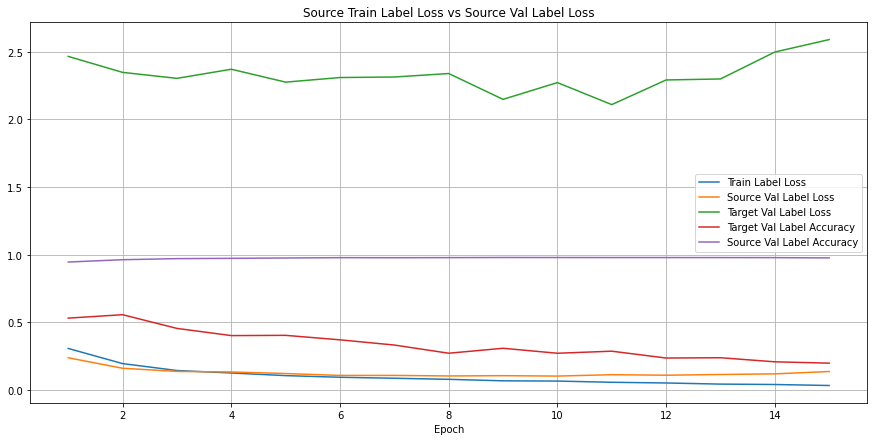

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

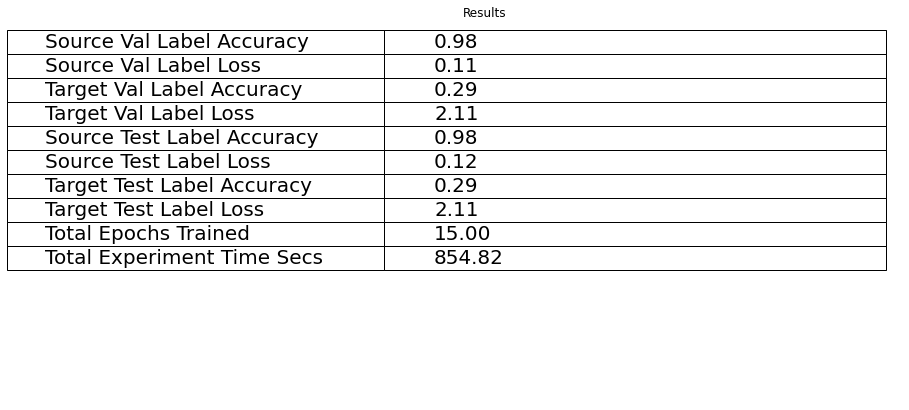

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

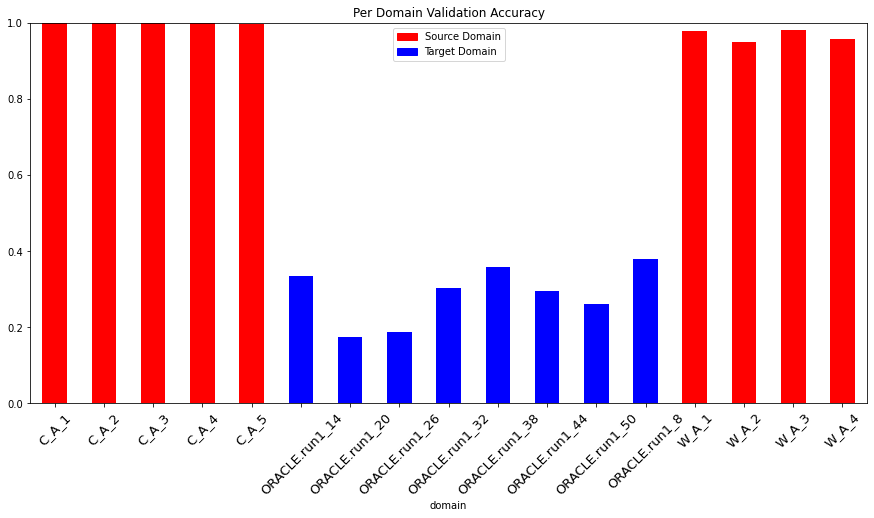

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9763986013986014 Target Test Label Accuracy: 0.2880859375
Source Val Label Accuracy: 0.9781468531468531 Target Val Label Accuracy: 0.2864583333333333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_3A:cores+wisig -> oracle.run1.framed", "parameters": {"experiment_name": "tl_3A:cores+wisig -> oracle.run1.framed", "device": "cuda", "lr": 0.001, "x_shape": [2, 200], "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 200]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features"